# Import all libraries

In [75]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import seaborn as sns

# Data Import and Clean

In [76]:

df = pd.read_csv('recipe_site_traffic_2212.csv')

df.high_traffic = df.high_traffic.fillna('Not High')
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')
df['servings'] = df['servings'].str.replace(' as a snack', '').astype(int)

def fill_missing(cat):
    df[cat] = df.groupby(['category','servings'])[cat].transform(lambda x: x.fillna(x.mean()))

for x in ['calories', 'carbohydrate', 'sugar', 'protein']:
    fill_missing(x)
df.isna().sum()


# encode high_traffic , High = 1
df['high_traffic'] = df['high_traffic'].map({'High': 1, 'Not High': 0})

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int32  
 7   high_traffic  947 non-null    int64  
dtypes: float64(4), int32(1), int64(2), object(1)
memory usage: 55.6+ KB


# Feature Engineering

In [50]:
# calculate the total grams for each macronutrient
df['total_grams'] = df['carbohydrate'] + df['sugar'] + df['protein']

# calculate the macronutrient percentages based on grams
df['carb_percent'] = df['carbohydrate'] / df['total_grams'] * 100
df['sugar_percent'] = df['sugar'] / df['total_grams'] * 100
df['protein_percent'] = df['protein'] / df['total_grams'] * 100

# create a new column 'diet_type' based on the macronutrient percentages
df.loc[df['carb_percent'] < 10, 'diet_type'] = 'Atkins Diet'
df.loc[(df['carb_percent'] >= 10) & (df['protein_percent'] >= 20), 'diet_type'] = 'Paleo Diet'
df.loc[(df['carb_percent'] >= 10) & (df['protein_percent'] < 20), 'diet_type'] = 'Mediterranean Diet'
df.loc[(df['carb_percent'] >= 45) & (df['protein_percent'] >= 20), 'diet_type'] = 'Vegan Diet'
df.loc[(df['carb_percent'] >= 10) & (df['carb_percent'] <= 30) & (df['protein_percent'] >= 20), 'diet_type'] = 'Modified Atkins Diet'
df.loc[(df['carb_percent'] >= 10) & (df['carb_percent'] <= 40) & (df['protein_percent'] >= 20), 'diet_type'] = 'Zone Diet'
df.loc[(df['carb_percent'] >= 10) & (df['carb_percent'] <= 50) & (df['protein_percent'] >= 15) & (df['sugar_percent'] <= 10), 'diet_type'] = 'Ketogenic Diet'
df.loc[(df['carb_percent'] >= 10) & (df['carb_percent'] <= 55) & (df['protein_percent'] >= 15), 'diet_type'] = 'DASH Diet'

In [51]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,total_grams,carb_percent,sugar_percent,protein_percent,diet_type
0,1,764.641333,20.072,7.013333,66.528,Pork,6,1,93.613333,21.441390,7.491810,71.066800,DASH Diet
1,2,35.480000,38.560,0.660000,0.920,Potato,4,1,40.140000,96.063777,1.644245,2.291978,Mediterranean Diet
2,3,914.280000,42.680,3.090000,2.880,Breakfast,1,0,48.650000,87.728674,6.351490,5.919836,Mediterranean Diet
3,4,97.030000,30.560,38.630000,0.020,Beverages,4,1,69.210000,44.155469,55.815634,0.028898,Mediterranean Diet
4,5,27.050000,1.850,0.800000,0.530,Beverages,4,0,3.180000,58.176101,25.157233,16.666667,Mediterranean Diet


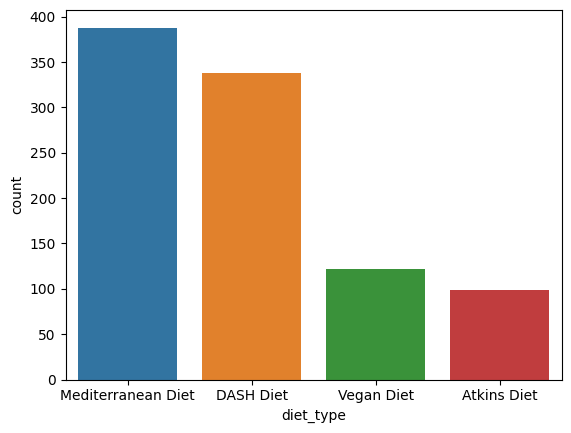

In [52]:
# count the occurrences of each diet type
grouped_df = df['diet_type'].value_counts().reset_index()

# rename the columns
grouped_df.columns = ['diet_type', 'count']

# create bar plot using Seaborn
sns.barplot(x='diet_type', y='count', data=grouped_df)

# show the plot
plt.show()

In [53]:
df = df.drop(['total_grams','carb_percent','sugar_percent','protein_percent'],axis=1)

# Train and Test Data

In [54]:


# split target column from features
X = df.drop(['high_traffic','recipe'], axis=1)
y = df.high_traffic

# instantiate the label encoder and transform the y column
y_enc = LabelEncoder().fit_transform(y)
y_enc = pd.Series(y_enc).astype('category')
y_enc.rename('high_traffic', inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, stratify = y_enc, random_state=22)

#for cat boosting
categorical_feature_indices = np.where(X.dtypes == object)[0]
print(categorical_feature_indices)
pool_train = Pool(X_train, y_train, cat_features = categorical_feature_indices)
pool_test = Pool(X_test, y_test, cat_features = categorical_feature_indices)

[4 6]


In [55]:

classifiers = [LogisticRegression(random_state=42),
               SVC(random_state=42, probability=True),
               KNeighborsClassifier(),
               GaussianNB(),
               GradientBoostingClassifier(random_state=42),
               XGBClassifier(random_state=42),
               DecisionTreeClassifier(random_state=42),
               AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42),
               ExtraTreesClassifier(random_state=42),
               RandomForestClassifier(random_state=42),
               CatBoostClassifier(random_state=42)]




# Preprocessing step of pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), make_column_selector(dtype_include=np.number)),
    ('cat', OneHotEncoder(), make_column_selector(dtype_include=object))])

# Define the feature selection step of pipeline
rfe_clf = RandomForestClassifier(n_estimators=100, random_state=42)
feat_selection = SelectFromModel(rfe_clf)

results_df = pd.DataFrame()

for clf in classifiers:
    if isinstance(clf, CatBoostClassifier):
        pipeline = make_pipeline(clf)
        clf.set_params(verbose=False)
        pipeline.fit(pool_train)
        y_pred = pipeline.predict(pool_test)
        y_prob = pipeline.predict_proba(pool_test)[:, 1]
    
    else:
        pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feat_selection', feat_selection),
        ('clf', clf)
        ])
        pipeline.fit(X_train, y_train)

        selected_features = pipeline.named_steps['preprocessor'].get_feature_names_out()[pipeline.named_steps['feat_selection'].get_support(indices=True)]
        selected_features = [feature.split('__', 1)[1] if '__' in feature else feature for feature in selected_features]
    
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc scores
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    #precision - recall curve data
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    test_precisions, test_recalls, _ = precision_recall_curve(y_test, y_prob)
    
    # confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_positives = fp / (fp + tn)
    false_negatives = fn / (fn + tp)
    
    results_df = results_df.append({'Model': clf.__class__.__name__,
                                    'Recall': recall,
                                    'Precision': precision,
                                    'Accuracy': accuracy,
                                    'F1': f1,
                                    'AUC-ROC': auc_roc,
                                    'False Positives': false_positives,
                                    'False Negatives': false_negatives,
                                    'FPR':fpr,
                                    'TPR':tpr,
                                    'test_precisions':test_precisions,
                                    'test_recalls':test_recalls,
                                    'Selected Features': selected_features,
                                    'Number of Features': len(selected_features)}, ignore_index=True)

results_df.iloc[:,:8].sort_values('Accuracy', ascending = False)

,Model,Recall,Precision,Accuracy,F1,AUC-ROC,False Positives,False Negatives
3,GaussianNB,0.919075,0.729358,0.743860,0.813299,0.688610,0.526786,0.080925
10,CatBoostClassifier,0.791908,0.782857,0.740351,0.787356,0.823054,0.339286,0.208092
0,LogisticRegression,0.919075,0.719457,0.733333,0.807107,0.734130,0.553571,0.080925
1,SVC,0.924855,0.717489,0.733333,0.808081,0.696145,0.562500,0.075145
9,RandomForestClassifier,0.872832,0.729469,0.726316,0.794737,0.727162,0.500000,0.127168
4,GradientBoostingClassifier,0.849711,0.720588,0.708772,0.779841,0.689023,0.508929,0.150289
8,ExtraTreesClassifier,0.855491,0.718447,0.708772,0.781003,0.716040,0.517857,0.144509
5,XGBClassifier,0.803468,0.723958,0.694737,0.761644,0.695938,0.473214,0.196532
2,KNeighborsClassifier,0.838150,0.707317,0.691228,0.767196,0.687061,0.535714,0.161850
7,AdaBoostClassifier,0.722543,0.735294,0.673684,0.728863,0.718260,0.401786,0.277457


In [56]:
X_train.columns

Index(['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings',
       'diet_type'],
      dtype='object')

# Visualize Performance of Models

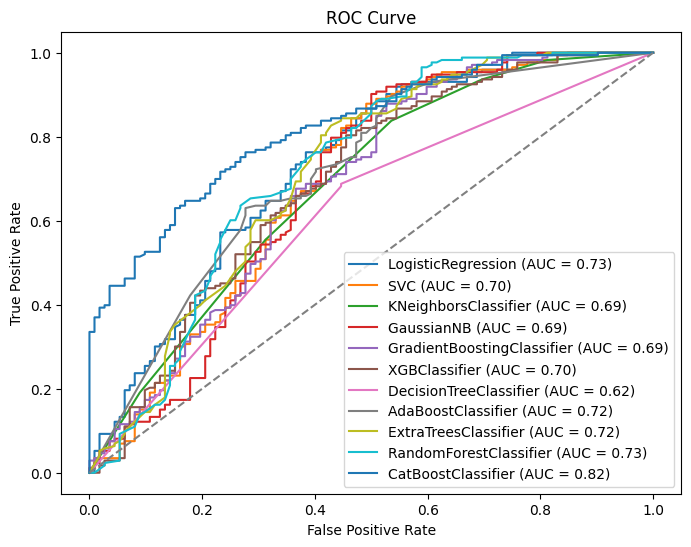

In [57]:
# Working function - only plots roc_auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(df):
    plt.figure(figsize=(8,6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    for model in df['Model'].unique():
        df_model = df[df['Model'] == model]
        roc_auc = df_model['AUC-ROC'].iloc[0]
        fpr = df_model['FPR'].iloc[0]
        tpr = df_model['TPR'].iloc[0]
        plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')
        
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_auc(results_df)

In [58]:
results_df.iloc[:,:8]

,Model,Recall,Precision,Accuracy,F1,AUC-ROC,False Positives,False Negatives
0,LogisticRegression,0.919075,0.719457,0.733333,0.807107,0.734130,0.553571,0.080925
1,SVC,0.924855,0.717489,0.733333,0.808081,0.696145,0.562500,0.075145
2,KNeighborsClassifier,0.838150,0.707317,0.691228,0.767196,0.687061,0.535714,0.161850
3,GaussianNB,0.919075,0.729358,0.743860,0.813299,0.688610,0.526786,0.080925
4,GradientBoostingClassifier,0.849711,0.720588,0.708772,0.779841,0.689023,0.508929,0.150289
5,XGBClassifier,0.803468,0.723958,0.694737,0.761644,0.695938,0.473214,0.196532
6,DecisionTreeClassifier,0.687861,0.704142,0.635088,0.695906,0.619426,0.446429,0.312139
7,AdaBoostClassifier,0.722543,0.735294,0.673684,0.728863,0.718260,0.401786,0.277457
8,ExtraTreesClassifier,0.855491,0.718447,0.708772,0.781003,0.716040,0.517857,0.144509
9,RandomForestClassifier,0.872832,0.729469,0.726316,0.794737,0.727162,0.500000,0.127168


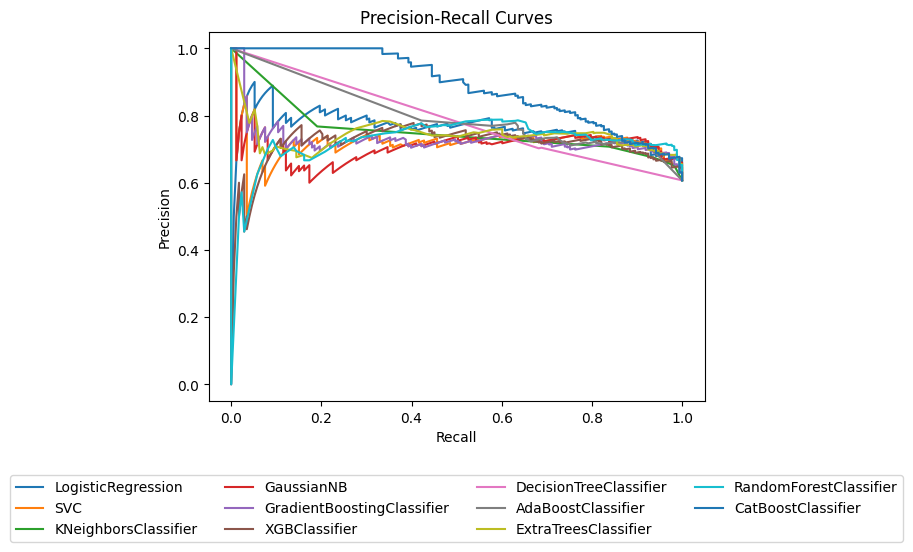

In [59]:
import matplotlib.pyplot as plt

def plot_precision_recall_curves(model_results):
    for i, row in model_results.iterrows():
        model_name = row['Model']
        test_precisions = row['test_precisions']
        test_recalls = row['test_recalls']
        plt.plot(test_recalls, test_precisions, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.4))
    plt.show()
plot_precision_recall_curves(results_df)

# HyperParameter Tuning on Best Three Models

In [ ]:
feat_selection = SelectKBest(f_classif, k=5)


rf_param_grid = {
    'clf__n_estimators': [50, 100, 200, 500],
    'clf__max_features': ['sqrt', 'log2', 0.5],
    'clf__max_depth': [10, 20, 30, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
}



adaboost_param_grid = {
    'clf__n_estimators': [50, 100, 200, 500],
    'clf__learning_rate': [0.01, 0.1, 0.5, 1],
    'clf__algorithm': ['SAMME', 'SAMME.R'],
    'clf__base_estimator__max_depth': [1, 2, 3, 4],
    'clf__base_estimator__min_samples_split': [2, 5, 10],
}


catboost_param_grid = {
    'clf__iterations': [100, 500],
    'clf__learning_rate': [0.01, 0.1, 0.5],
    'clf__depth': [3, 5, 7],
    'clf__l2_leaf_reg': [1, 3, 5],
}



# List of classifiers and their respective hyperparameter grids
classifiers = [
    {'name': 'Adaboost', 'clf': AdaBoostClassifier(), 'param_grid': adaboost_param_grid},
    {'name': 'RandomForest', 'clf': RandomForestClassifier(), 'param_grid': rf_param_grid},
    {'name': 'CatBoost', 'clf': CatBoostClassifier(verbose=False), 'param_grid': catboost_param_grid}
]

In [ ]:

# Results dataframe initialization
results_df2 = pd.DataFrame()

# Iterate through each classifier and perform grid search
for clf_dict in classifiers:
    clf_name = clf_dict['name']
    clf = clf_dict['clf']
    param_grid = clf_dict['param_grid']
    clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('feat_selection', feat_selection), ('clf', clf)])
    grid_search = GridSearchCV(clf_pipeline, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print("Best hyperparameters for", clf_name + ":", best_params)
    
    # Evaluate best model
    best_model = clf_pipeline.set_params(**best_params)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    auc_roc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average="binary")
    precision = precision_score(y_test, y_pred, average="binary")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="binary")
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_positives = fp / (fp + tn)
    false_negatives = fn / (fn + tp)
    
    # Append results to dataframe
    results_df2 = results_df2.append({'Model': clf.__class__.__name__,
                                    'Recall': recall,
                                    'Precision': precision,
                                    'Accuracy': accuracy,
                                    'F1': f1,
                                    'AUC-ROC': auc_roc,
                                    'False Positives': false_positives,
                                    'False Negatives': false_negatives}, ignore_index=True)

results_df2.sort_values('Accuracy', ascending = False)  

In [ ]:
results_df2.sort_values('Accuracy', ascending = False)  

In [ ]:
results_df.sort_values('Precision', ascending = False)  

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(df):
    plt.figure(figsize=(8,6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    for model in df['Model'].unique():
        df_model = df[df['Model'] == model]
        roc_auc = df_model['AUC-ROC'].iloc[0]
        fpr = df_model['FPR'].iloc[0]
        tpr = df_model['TPR'].iloc[0]
        plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')
        
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_auc(results_df)

In [ ]:
results_df.columns

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_auc_roc(df):
    """
    This function plots the AUC-ROC scores for all models in the input dataframe on a single plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    for name, group in df.groupby('Model'):
        ax.plot(group.index, group['AUC-ROC'], label=name)
    ax.set_xlabel('Model Name')
    ax.set_ylabel('AUC-ROC Score')
    ax.set_title('AUC-ROC Scores by Model')
    ax.legend(loc='best')
    plt.show()

plot_auc_roc(results_df)


In [ ]:
stop here

In [72]:
X_train.reset_index(inplace=True)

X_train=X_train.drop('index', axis=1)

# Select columns for one-hot encoding
cols_to_encode = ['diet_type', 'category']

# Initialize one-hot encoder
encoder = OneHotEncoder()

# Fit encoder to selected columns and transform them
encoded_cols = pd.DataFrame(encoder.fit_transform(X_train[cols_to_encode]).toarray(), 
                            columns=encoder.get_feature_names_out(cols_to_encode))

# Drop original columns from the dataframe
X_train = X_train.drop(cols_to_encode, axis=1)

# Concatenate the encoded columns with the original dataframe
X_train = pd.concat([X_train, encoded_cols], axis=1)

# Define hyperparameters for logistic regression model
logreg_params = {
    'C': 0.001,
    'l1_ratio': 0.25,
    'max_iter': 100,
    'penalty': 'none',
    'solver': 'newton-cg'
}

# Initialize logistic regression model with hyperparameters
logreg = LogisticRegression(**logreg_params)
# Perform feature selection using L1 regularization
selector = SelectFromModel(logreg)
selector.fit(X_train, y_train)

# Fit logistic regression model to the selected features
selected_features = X_train.columns[selector.get_support()]
logreg.fit(X_train[selected_features], y_train)

# Get selected features and corresponding coefficients
coefficients = logreg.coef_[0]


KeyError: "['index'] not found in axis"

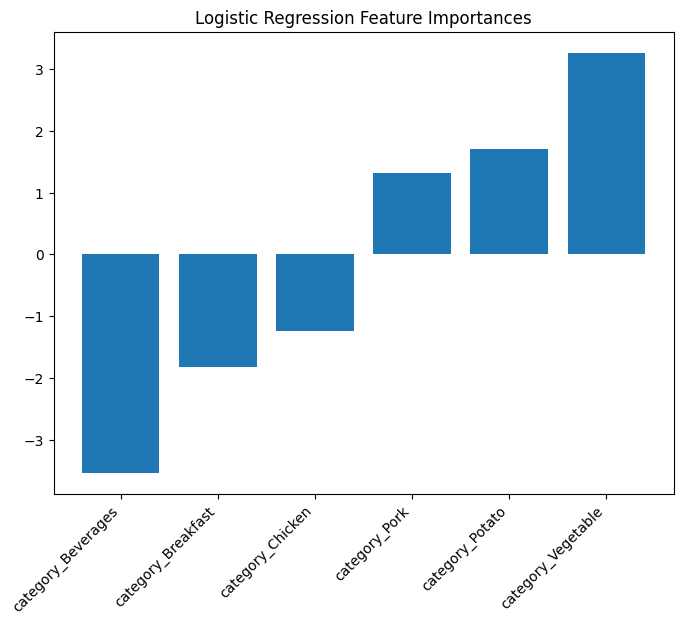

In [74]:

# Plot feature importances
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(len(selected_features)), coefficients)
ax.set_xticks(np.arange(len(selected_features)))
ax.set_xticklabels(selected_features, rotation=45, ha='right')
ax.set_title("Logistic Regression Feature Importances")
plt.show()
